# ***Network Comparator* v1.0**

L'obbiettivo di questo notebook è di automatizzare il più possibile l'addestramento e il testing di diverse reti neurali sul **dataset GTSRB** (*German Traffic Sign Recognition Benchmark*) con lo scopo di confrontarne le performance e selezionare le tecniche e le topologie che forniscono risultati migliori.
In particolare verranno testate architetture custom e reti preaddestrate quali *VGG16*, *VGG19*, *ResNet50V2*, *InceptionV3* utilizzando tecniche di **Transfer Learning**.

Si tratta cioé di un problema di **classificazione multi-classe**, in cui ad ogni esempio deve essere associata l'appartenenza ad una e una sola tra le 43 classi di cui è composto il dataset. Ogni classe corrisponde ad un diverso tipo di cartello stradale.

Il **dataset** contiene **51.839 esempi** totali, di cui:

- 39.209 di training
- 12.630 di test

Il dataset è inoltre **fortemente sbilanciato**, con classi sovra-rappresentate ed altre notevolmente sotto-rappresentate.

Inoltre per ogni immagine esistono 29 varianti della stessa a cui sono state applicate tecniche di **Data Augmentation** (che consentono di aumentare il numero di esempi di training senza effettivamente collezionarne di nuovi), a partire da vari resize dell'immagine originale fino a filtering più complessi.

In questo progetto veranno considerate e testate anche altre tecniche di Data Augmentation, con l'obbiettivo di estrarre nuovi esempi aumentando l'eterogeneità del training set.

*Dataset*: https://benchmark.ini.rub.de/gtsrb_news.html



```
# README
Per eseguire in locale è necessario scaricare il dataset (cartella 'archive') e inserirlo insieme a questo codice nella cartella 'Desktop/progetto'.
Inoltre per testare Data Augmentation è necessario creare la cartella 'Augmented' all'interno di 'archive'.
```



In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.utils import shuffle
from matplotlib import pyplot
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical, save_img
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, MaxPooling2D, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import AUC
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, serialize
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow_addons.metrics import F1Score

# Analisi del Dataset
Lo scopo di questa sezione di codice è di studiare la distribuzione del dataset con l'obbiettivo di compiere alcune analisi preliminari che consentano di selezionare i modelli più appropriati da addestrare.

- **[data_dir, train_path, test_path, augmented_path]** sono i percorsi delle directory in cui si trovano rispettivamente i file del progetto, le immagini di training, di test, e le immagini create con le tecniche di Data Augmentation.

- **[classes]** è un dizionario che associa ad ogni indice delle cartelle di Training il rispettivo nome della categoria (classe).

Gli **istogrammi** di sotto danno un'idea di come siano distribuiti i vari esempi del training set e del test set. Questi ultimi vanno a riportare infatti il numero di esempi di training e di test per ognuna delle 43 classi. 

Risulta interessante notare come la distribuzione del test set sia tutto sommato abbastanza vicina a quella del training set (nonostante alcune anomalie), il che è alquanto importante per compiere dei test che siano statisticamente affidabili.

# Metrica
Con riferimento allo sbilanciamento dei Dataset, si è scelto di addottare come metrica di riferimento l'***average-weighted F1-Score***.

L'*F1-Score* non è che altro che la media armonica di *Precision* e *Recall* (si è scelto di non provilegiare nessuna delle due dato che non è di nostro interesse minimizzare il *false positive rate* né il *false negative rate*):

$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$

Poiché si tratta di una metrica pensata per la classificazione binaria, l'F1-Score viene calcolato in modalità *OneVsAll* per ciascuna classe del dataset, dopodiché si determina la media pesata di questi 43 valori di F1 sulla distribuzione del training set (oppure su quella del test set, se stiamo valutando le performance su quest'ultimo).
  

In [ ]:
images = None; labels = None; x_train = None; x_test = None; y_train = None; y_test = None; input_shape = None; aug = None

In [ ]:
data_dir = 'Desktop/progetto/archive'     # Path di root
train_path = data_dir + '/Train'          # Path di training
test_path = data_dir + '/Test'            # Path di test
augmented_path=data_dir + '/Augmented'    # Path per data augmentation

Distribuzione Training Set


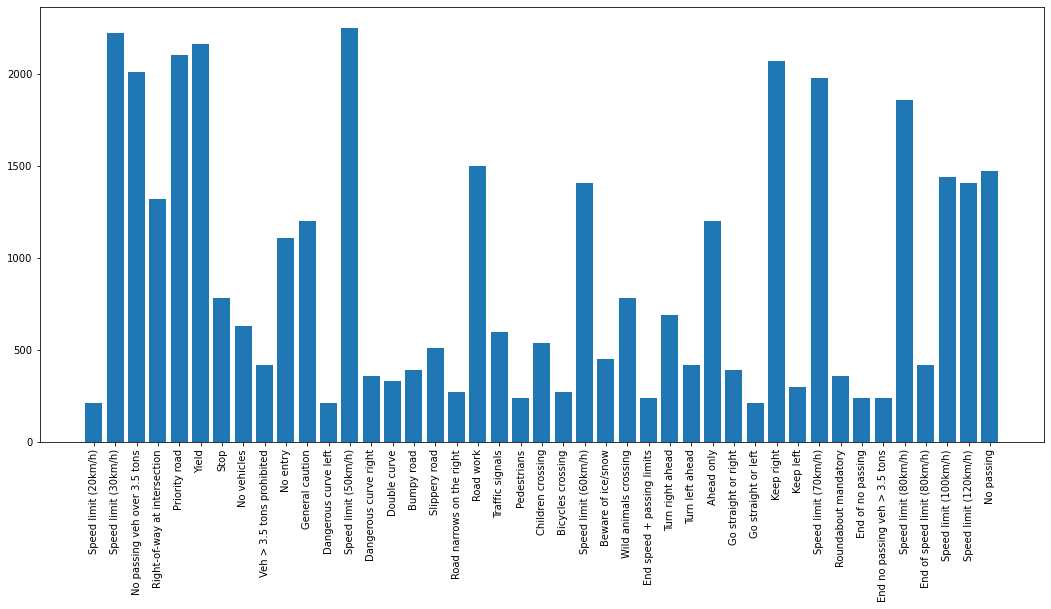

Distribuzione Test Set


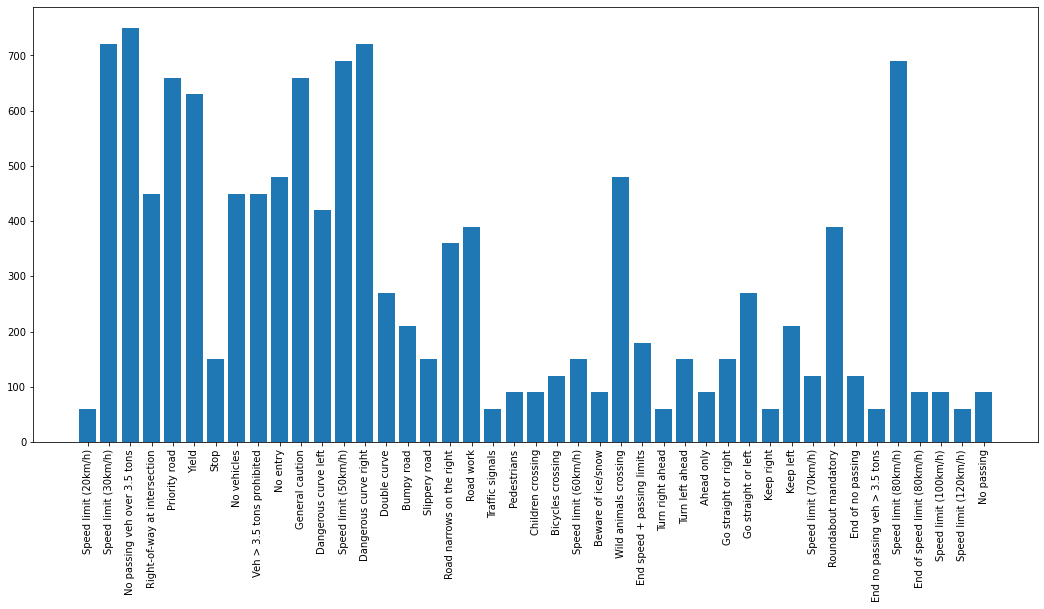

In [ ]:
# Numero di classi = Numero di subdirectory nella cartella di training
NUM_CATEGORIES = len(os.listdir(train_path)) 

# Etichette delle classi
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }


folders = os.listdir(train_path)    # Lista delle subdirectory contenute in Train
train_number = []                   # Lista che conterrà il numero di esempi per ciascuna classe
class_num = []                      # Lista che conterrà il nome associato ad ogni classe

for folder in folders:                                  # Per ogni cartella:
    train_files = os.listdir(train_path + '/' + folder) # Si estrae n° di elementi di quest'ultima
    train_number.append(len(train_files))               # Si aggiunge alla lista train_number
    class_num.append(classes[int(folder)])              # Si aggiunge il nome della classe alla lista class_num

train_number = np.array(train_number) # Conversione in numpy array

# Si disegna l'istogramma che rappresenta il numero di esempi per ogni classe del training set
print("Distribuzione Training Set")
plt.figure(figsize=(18,8))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

# Si determina la distribuzione di probabilità delle classi del training set
# dividendo il numero di esempi di ogni classe per il numero di esempi totali
distr_train = np.divide(train_number,np.sum(train_number))


test_number = np.zeros(NUM_CATEGORIES)        # Inizializzazione array train_number
df = pd.read_csv (data_dir + '/Test.csv')     # Caricamento csv di test
test_labels = df['ClassId'].tolist()          # Caricamento della colonna contenente le classi di test
for i in test_labels:                         
  test_number[i] = test_number[i] + 1         # Conteggio del numero di elementi di ogni classe

# Si disegna l'istogramma che rappresenta il numero di esempi per ogni classe del test set
print("Distribuzione Test Set")
plt.figure(figsize=(18,8))
plt.bar(class_num, test_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

# Si determina la distribuzione di probabilità delle classi del training set
# dividendo il numero di esempi di ogni classe per il numero di esempi totali
distr_test = np.divide(test_number,np.sum(test_number))

# Funzioni utili
- **load_train_data(...)** è una funzione che carica ciascuna immagine del dataset di training e la converte in un array tridimensionale. Ogni immagine viene dunque inserita in una lista in questa forma, inoltre viene creata una seconda lista che contiene la categoria (numerica) di ogni esempio nello stesso ordine. Questa funzione è in grado inoltre di caricare immagini di cui è stato fatto Data Augmentation a seconda del valore del flag *augmented*.

- **load_test_data(...)** è una funzione che carica ciascuna immagine del dataset di test e la converte in un array tridimensionale. Ogni immagine viene dunque inserita in una lista in questa forma, inoltre viene creata una seconda lista che contiene la categoria (numerica) di ogni esempio nello stesso ordine.

- **init_data(...)** è una funzione che:
  - richiama *load_train_data()* e *load_test_data()* per effettuare il caricamento delle immagini

  - mescola le immagini di training e di test in maniera casuale in modo da velocizzare il più possibile l'addestramento

  - converte ogni categoria numerica in *one-hot encoding*

  - normalizza ogni pixel dividendo per il valore massimo (255)

  - stabilisce la dimensione che le reti utilizzeranno per l'addestramento sulla base della dimensione delle immagini che sono state appena caricate in memoria.

- **do_data_augmentation(...)** è una funzione in grado di effettuare data augmentation per ogni immagine del training set. In particolare per ogni immagine applica un ribaltamento e una piccola rotazione casuale e la salva nella directory Augmented/*i*x*j* dove *i* e *j* sono le dimensioni delle immagini di output. Questa funzione, in combinazione col flag *augmented* settato a True permette di raddoppiare il numero di esempi di addestramento, generando una nuova immagine per ogni pattern di training.
Esempi di utilizzo: 

```
do_data_augmentation(30,30) ---> applica data augmentation ad ogni esempio di training e crea immagini 30x30 che verranno salvate in "Augmented/30x30"
do_data_augmentation(32,32) ---> applica data augmentation ad ogni esempio di training e crea immagini 30x30 che verranno salvate in "Augmented/32x32"
do_data_augmentation(75,75) ---> applica data augmentation ad ogni esempio di training e crea immagini 30x30 che verranno salvate in "Augmented/75x75"
```



- **plot_results(...)** è una funzione che permette di visualizzare l'andamento grafico delle metriche epoca per epoca una volta concluse tutte le epoche di addestramento. In particolar modo in questa istanza vogliamo visualizzare: l'andamento della Loss, l'andamento dell'F1-Score pesato sulla distribuzione del dataset, l'andamento dell'accuracy e della validation accuracy e il grafico precision-recall.

- **compile_train_evaluate(...)** è una funzione che, ricevuto in input un modello esegue le operazioni di compiling, training e testing dello stesso. Oltre a stampare alcune caratteristiche del modello che verrà addestrato, lo compila secondo le metriche specificate in *metrics*, lo addestra utilizzando il set di iperparametri desiderato, ed infine ne valuta le performance sfruttando il test set e stampando i risultati ed i grafici ottenuti.
  

In [ ]:
# IMG_HEIGHT: altezza dell'immagine
# IMG_WIDTH: larghezza dell'immagine
# augmented: flag per caricamento augmented data
def load_train_data(IMG_HEIGHT, IMG_WIDTH, augmented):
    # Creazione liste per caricamento immagini e relative etichette del training set
    images = list()
    labels = list()

    # num_iter=1 --> caricamento solo del training set
    # num_iter=2 --> caricamento del training set + augmented data
    num_iter=1
    if augmented:
        num_iter=2
    path=train_path # Path del training set, di default

    for i in range(num_iter):
        # Se inizia la seconda iterazione si cambia il path in quello degli augmented data
        if augmented and i==1:
            path=augmented_path+'/'+str(IMG_HEIGHT)+'x'+str(IMG_WIDTH) # Cambio directory
        for category in range(NUM_CATEGORIES):
            categories = os.path.join(path, str(category))    # Aggiunge al path il nome della directory in cui leggere le immagini della classe
            for img in os.listdir(categories):                # Per ogni immagine all'interno della classe:
                # Viene caricata l'immagine come jpg della dimensione specificata
                img = load_img(os.path.join(categories, img), target_size=(IMG_HEIGHT, IMG_WIDTH))
                # Si converte l'immagine in array tridimensionale
                image = img_to_array(img)
                # Si aggiunge l'immagine convertita in coda alla lista delle immagini
                images.append(image)
                # Si aggiunge la relativa etichetta in coda alla lista delle label
                labels.append(category)
                
    return images, labels

In [ ]:
# IMG_HEIGHT: altezza dell'immagine
# IMG_WIDTH: larghezza dell'immagine
def load_test_data(IMG_HEIGHT, IMG_WIDTH):
  df = pd.read_csv (data_dir + '/Test.csv')     # Caricamento del csv di test
  test_images = list()                          # Creazione lista immagini di test
  test_labels = df['ClassId'].tolist()          # Lettura della colonna delle label di test
  for img in os.listdir(test_path):             # Per ogni immagine all'interno del path di test
    # Viene caricata l'immagine come jpg della dimensione specificata
    img = load_img(os.path.join(test_path, img), target_size=(IMG_HEIGHT, IMG_WIDTH))
    # Si converte l'immagine in array tridimensionale
    image = img_to_array(img)
    # Si aggiunge l'immagine convertita in coda alla lista delle immagini
    test_images.append(image)
    
  return test_images, test_labels

In [ ]:
# h: altezza dell'immagine
# w: larghezza dell'immagine
# augmented: flag per caricamento augmented data
def init_data(h,w, augmented):
  print("Caricamento immagini dal dataset...\n")   

  train_images, train_labels = load_train_data(h,w,augmented)     # Caricamento delle immagini di train e delle rispettive label
  train_labels = to_categorical(train_labels)                     # Conversione delle label in one-hot encoding

  # Si mescolano gli esempi e le rispettive label del training set simultaneamente per evitare che la rete
  # impari a generalizzare su esempi nell'ordine in cui sono presentati nel dataset
  x_train, y_train = shuffle(np.array(train_images), train_labels, random_state=0)

  test_images, test_labels = load_test_data(h,w)                  # Caricamento delle immagini di test e delle rispettive label
  test_labels = to_categorical(test_labels)                       # Conversione delle label in one-hot encoding
  # Si mescolano gli esempi e le rispettive label del test set simultaneamente
  x_test, y_test = shuffle(np.array(test_images), test_labels, random_state=0)

  x_train/=255              # Normalizzazione nel range [0,1] dei pixel del trainin set
  x_test/=255               # Normalizzazione nel range [0,1] dei pixel del test set
  input_shape=(h, w, 3)     # Definizione della dimensione dell'input di ogni rete

  return (images, labels, x_train, x_test, y_train, y_test, input_shape)

In [ ]:
# h: altezza dell'immagine
# w: larghezza dell'immagine
# ATTENZIONE: da eseguirsi singolarmente come descritto nelle note relative al "Main"
def do_data_augmentation(h,w):
    # Caricamento delle immagini del dataset tranne quelle con data augmentation
    images, labels, x_train, x_test, y_train, y_test, input_shape = init_data(h,w,False)

    # Creazione subdirectory "h x w"
    path = augmented_path+'/'+str(h)+'x'+str(w)
    os.mkdir(path) 

    # Si creano le directory da 0 a 42 per contenere i pattern di data augmentation
    for i in range(NUM_CATEGORIES):
        os.mkdir(path+"/"+str(i))

    # Modello per fare data augmentation
    data_augmentation = tf.keras.Sequential([
                # Si capovolge l'immagine orizzontalmente o verticalmente in maniera casuale
                layers.RandomFlip("horizontal_and_vertical"), 
                # Si applica una rotazione casuale
                layers.RandomRotation(0.2)])
    
    for i in range(len(x_train)):
        # Ogni immagine viene espansa di dimensione, modificata con il modello di data augmentation,
        # convertita in array, e poi salvata con un nome che segue l'indice del ciclo
        image_aug = tf.expand_dims(x_train[i], 0)
        augmented_image = data_augmentation(image_aug)
        img_array = img_to_array(augmented_image[0])
        save_img(path+'/{0}/{1}.png'.format(np.argmax(y_train[i]),i),img_array)
        print(str(i)+ "   "+ str(np.argmax(y_train[i])))

In [ ]:
# history: history del modello addestrato
def plot_results(history):
  # Dimensione della figura contenente la griglia
  plt.figure(figsize=(21,5))

  # All'interno della figura si definisce una griglia 1x3 dove con gli indici:
  # 1 --> si indicizza il grafico della funzione di loss
  # 2 --> si indicizza il grafico dell'f1-score di training e validation
  # 3 --> si indicizza il grafico della accuracy di training e validation

  plt.subplot(1,3,1)
  plt.plot(history.history['loss'], color='r')
  plt.title('Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Loss'], loc='upper left')

  plt.subplot(1,3,2)
  # Valore medio pesato (in base alla distribuzione del training set) dell'f1-score
  # OneVsAll di ogni classe per ogni epoca:
  f1score_avg = np.zeros(history.params['epochs'])      # - Per l'addestramento
  f1score_avg_val = np.zeros(history.params['epochs'])  # - Per il validation
  for i in range(history.params['epochs']):             # Per ogni epoca:
    # Estraggo array di f1-score OneVsAll di ogni classe in fase di training
    current = history.history['f1_score'][i]
    # Determino il valore medio pesato dell'f1-score di training nella corrispondente epoca
    f1score_avg[i] = np.average(np.array(current),weights = distr_train)
    # Estraggo array di f1-score OneVsAll di ogni classe in fase di validation
    current_val = history.history['val_f1_score'][i]
    # Determino il valore medio pesato dell'f1-score di validation nella corrispondente epoca
    f1score_avg_val[i] = np.average(np.array(current_val),weights = distr_train)
  plt.plot(f1score_avg, color='orange')
  plt.plot(f1score_avg_val, color='m')
  plt.title('F1Score')
  plt.ylabel('F1Score')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.subplot(1,3,3)
  plt.plot(history.history['accuracy'], color='g')
  plt.plot(history.history['val_accuracy'], color='b')
  plt.title('Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Corregge la posizione relativa dei grafici
  plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
  
  plt.show()

In [ ]:
# model: modello da compilare, addestrare e testare
# current_params: dizionario contenente il set di iperparametri scelto
# name: stringa contenenete il nome del modello
def compile_train_evaluate(model, current_params, name):
  # Si stampa:
  # 1) il nome del modello
  # 2) Se si utilizza data augmentation o meno
  # 3) il set di iperparametri corrente
  # 4) informazioni specifiche sull'ottimizzatore scelto
  print(name)
  print("Data Augmentation: " + str(aug))
  print("Iperparametri: [epochs: {0}, loss: {1}, batch_size: {2}, validation_split: {3}]".format(current_params["epochs"],current_params["loss"],current_params["batch_size"],current_params["validation_split"]))
  opt = current_params["optimizer"]
  print("Ottimizzatore: "+ str(serialize(opt)))


  # Calcolo e stampa del numero di paramentri addestrabili, non addestrabili e totali
  trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
  nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
  totalParams = trainableParams + nonTrainableParams
  print("Parametri addestrabili: " + str(trainableParams))
  print("Parametri non addestrabili: " + str(nonTrainableParams))
  print("Parametri totali: " + str(totalParams) + '\n')

  # Compilazione del modello con il set di iperparametri scelti
  model.compile(loss=current_params["loss"],optimizer=current_params["optimizer"],metrics=metrics)
  # Addestramento del modello e salvataggio dello storico
  history = model.fit(x_train, y_train,validation_split=current_params["validation_split"],epochs=current_params["epochs"],callbacks=current_params["callback"])
  # Testing del modello e salvataggio delle metriche
  loss, f1score, accuracy, precision, recall = model.evaluate(x_test, y_test)
  # Media pesata dell'array OneVSAll f1-score rispetto alla ditribuzione di probabilità del test set
  f1score_avg = np.average(np.array(f1score), weights = distr_test) 
  # Stampa dei risultati di test
  print('test set f1_score avg-weighted: ', f1score_avg) 
  print('test set accuracy: ', accuracy * 100)
  print('test set precision: ', precision * 100)
  print('test set recall: ', recall * 100)
  # Plot dei grafici
  plot_results(history)
  print('\n')

# Modelli
Segue l'elenco dei modelli testati (tra parentesi è indicato il numero identificativo del modello corrispondente):
- **MyNetwork (1):** 
Si tratta di una semplice CNN costituita da tre livelli convoluzionali, di cui i primi due seguiti da Max Pooling 2x2 e Dropout.
Si utilizzano 32 filtri per il primo livello di convoluzione, e 64 per gli ultimi due, con kernel 3x3. Come funzione di attivazione viene sempre utilizzata la ReLU.
Seguono infine due layer fully-connected rispettivamente da 64 e poi 43 neuroni, il cui ultimo livello permette di ottenere le distibuzioni di probabilità delle classi utilizzando SoftMax come attivazione.

- **MyNetworkDeeper (2):** 
Si tratta di una CNN simile a *MyNetwork*, la cui capacità è stata aumentata per poter gestire meglio un dataset al quale viene applicato Data Augmentation. Risulta costituita da quattro livelli convoluzionali, di cui i primi tre seguiti da Max Pooling 2x2 e Dropout.
Si utilizzano 32 filtri per il primo livello di convoluzione, 64 per il secondo e 128 per gli ultimi due, con kernel 3x3. Come funzione di attivazione viene sempre utilizzata la ReLU.
Seguono infine due layer fully-connected rispettivamente da 128 e poi 43 neuroni, il cui ultimo livello permette di ottenere le distibuzioni di probabilità delle classi utilizzando SoftMax come attivazione.
Rispetto a *MyNetwork*, questo modello applica padding ("same") ai primi 3 livelli convoluzionali, in maniera tale da restringere la dimensione delle feature map solo attraverso il padding.

- **VGG16_net (100):** 
Si tratta di una VGG16 pre-addestrata per tutti i livelli convoluzionali su ImageNet. Si utilizza questo modello per effettuare Transfer Learning, eliminando i layer fully-connected della VGG16 e aggiungendo:
  - un livello fully-connected da 1000 neuroni con ReLU
  - un livello di Batch-Normalization
  - un livello fully-connected da 256 neuroni con ReLU
  - un livello fully-connected (di output) da 43 neuroni con SoftMax

- **VGG19_net (200):**
Si tratta di una VGG19 pre-addestrata per tutti i livelli convoluzionali su ImageNet. Si utilizza questo modello per effettuare Transfer Learning, eliminando i layer fully-connected della VGG19 e aggiungendo:
  - un livello fully-connected da 1000 neuroni con ReLU
  - un livello di Batch-Normalization
  - un livello fully-connected da 256 neuroni con ReLU
  - un livello fully-connected (di output) da 43 neuroni con SoftMax

- **ResNet50V2_net (300):**
Si tratta di una ResNet50V2 pre-addestrata per tutti i livelli convoluzionali su ImageNet. Si utilizza questo modello per effettuare Transfer Learning, eliminando i layer fully-connected della ResNet e aggiungendo:
  - un livello fully-connected da 1000 neuroni con ReLU
  - un livello fully-connected (di output) da 43 neuroni con SoftMax

- **InceptionV3_net (400):**
Si tratta di una InceptionV3 pre-addestrata per tutti i livelli convoluzionali su ImageNet. Si utilizza questo modello per effettuare Transfer Learning, eliminando i layer fully-connected della Inception e aggiungendo:
  - un livello di Dropout con rate 0,5
  - un livello fully-connected da 1000 neuroni con ReLU
  - un livello fully-connected (di output) da 43 neuroni con SoftMax

Ogni metodo riceve in ingresso un numero variabile di elementi che rappresentano i diversi set di iperparametri che è necessario testare.
  

In [ ]:
# h_params: lista delle posizioni dei set di iperparamentri da testare
def my_network(*h_params):

  name="Model Name: MyNetwork"

  for pos_dict in h_params:
    
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))

    model.add(Flatten())

    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(NUM_CATEGORIES, activation='softmax'))

    current_params = hyp_set[pos_dict]
    compile_train_evaluate(model, current_params,name)

In [ ]:
# h_params: lista delle posizioni dei set di iperparamentri da testare
def my_network_deeper(*h_params):

  name="Model Name: MyNetworkDeeper"

  for pos_dict in h_params:
    
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))

    model.add(Flatten())

    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(NUM_CATEGORIES, activation='softmax'))

    current_params = hyp_set[pos_dict]
    compile_train_evaluate(model, current_params,name)

In [ ]:
 # h_params: lista delle posizioni dei set di iperparamentri da testare
 def VGG16_net(*h_params):
   
   name="Model Name: VGG16"
   
   for pos_dict in h_params:

      base_model=VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

      model=Sequential([
          base_model,
        Flatten(),
        Dense(1000, activation='relu'),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dense(units=NUM_CATEGORIES, activation='softmax')
      ])
      
      for layer in base_model.layers:
          layer.trainable = False
          
      current_params = hyp_set[pos_dict]
      compile_train_evaluate(model, current_params,name)

In [ ]:
 # h_params: lista delle posizioni dei set di iperparamentri da testare
 def VGG19_net(*h_params):
   
   name="Model Name: VGG19"
   
   for pos_dict in h_params:
      base_model=VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
      model=Sequential([
          base_model,
        Flatten(),
        Dense(1000, activation='relu'),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dense(units=NUM_CATEGORIES, activation='softmax')
      ])
      
      for layer in base_model.layers:
          layer.trainable = False
          
      current_params = hyp_set[pos_dict]
      compile_train_evaluate(model, current_params,name)

In [ ]:
 # h_params: lista delle posizioni dei set di iperparamentri da testare
 def ResNet50V2_net(*h_params):
   
   name="Model Name: ResNet50V2"
   
   for pos_dict in h_params:
      base_model=ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
      model=Sequential([
          base_model,
        Flatten(),
        Dense(1000, activation='relu'),
        Dense(units=NUM_CATEGORIES, activation='softmax')
      ])
      
      for layer in base_model.layers:
          layer.trainable = False
          
      current_params = hyp_set[pos_dict]
      compile_train_evaluate(model, current_params,name)

In [ ]:
 # h_params: lista delle posizioni dei set di iperparamentri da testare
 def InceptionV3_net(*h_params):
   
   name="Model Name: InceptionV3"
   
   for pos_dict in h_params:
      base_model=InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
      model=Sequential([
          base_model,
        Flatten(),
        Dropout(0.5),
        Dense(1000, activation='relu'),
        Dense(units=NUM_CATEGORIES, activation='softmax')
      ])

      for layer in base_model.layers:
          layer.trainable = False
          
      current_params = hyp_set[pos_dict]
      compile_train_evaluate(model, current_params,name)

# Main
Questa sezione di codice contiene tutti i principali parametri su cui è necessario intervenire per addestrare e testare le performance di diverse reti in cascata. In particolare le sclete più importanti di addestramento devono essere fatte su:

- **[models_to_run]** è una lista di interi dove ciascun numero è associato ad un modello diverso da testare. I modelli vengono dunque addestrati e testati 
  nella sequenza specificata utilizzando vari set di iperparametri che verrano
  elencati nella lista [hyp_set].

  I numeri delle reti sono raggruppati nel seguente modo:

  - Reti 1-99 : *modelli custom*

  - Reti 100-199 : *modelli VGG16*

  - Reti 200-299 : *modelli VGG19*

  - Reti 300-399 : *modelli ResNet50V2*

  - Reti 400-499 : *modelli InceptionV3*
  
  È possibile conoscere l' identificativo di ogni modello controllando il numero indicato tra parentesi nella descrizione del modello stesso.

```
***IMPORTANTE*** 
- Inserendo il segno meno "-" davanti al numero del modello, quest'ultimo verrà testato senza caricare le immagini costruite con le tecniche di
Data Augmentation descritte precedentemente.
- Inserendo il segno più "+" davanti al numero del modello (oppure non inserendo nessun segno), quest'ultimo verrà testato caricando le immagini 
costruite con le tecniche di Data Augmentation descritte precedentemente.

ESEMPI:
models_to_run = [-1] # Testo MyNetwork senza Data Augmentation
models_to_run = [1] # Testo MyNetwork con Data Augmentation
models_to_run = [-100,100] # Testo VGG16_net due volte in sequenza, senza e poi con DataAugmentation
```



- **[hyp_set]** è una lista di dizionari in cui ogni entry rappresenta un iperparametro e il relativo valore associato. Di conseguenza è possibile addestrare lo stesso modello in sequenza su set di iperparametri diversi. Ogni set è associato ad un indice (quello della lista) a partire da 0.

- **[metrics]** è la lista delle metriche che verranno stampate durante 
l'addestramento dei modelli. Si rimanda alla sezione *Metrica* per la presentazione di quella che abbiamo scelto come riferimento per valutare la bontà dei modelli: l'*average-weighthed F1-Score*.

  
Infine in questa parte di codice avviene il *binding* tra il numero intero che rappresenta il modello e la funzione che effettivamente definisce il modello stesso. Poiché ogni network ha una certa dimensione minima di immagini che può processare, il caricamento delle immagini dal dataset verrà fatto modello per modello.
Tutti i modelli da testare verranno dunque addestrati e valutati in sequenza, sui set di iperaparametri specificati.

In [ ]:
"""
do_data_augmentation(30,30)
do_data_augmentation(32,32)
do_data_augmentation(75,75)
"""

'\ndo_data_augmentation(30,30)\ndo_data_augmentation(32,32)\ndo_data_augmentation(75,75)\n'

In [ ]:
# main
models_to_run = [-1,1,-2,2,-100,100,-200,200,-300,300,-400,400]

hyp_set = [
           {"epochs": 15, "loss": 'categorical_crossentropy', "optimizer": Adam(learning_rate=0.001), "batch_size": 256, "validation_split": 0.3, "callback": None}, # My...
           {"epochs": 15, "loss": 'categorical_crossentropy', "optimizer": SGD(learning_rate=0.001, momentum=0.9), "batch_size": 64, "validation_split": 0.3, "callback": None}, # VGG
           {"epochs": 15, "loss": 'categorical_crossentropy', "optimizer": Adam(learning_rate=0.001), "batch_size": 64, "validation_split": 0.3, "callback": ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2)}, # ResNet
           {"epochs": 15, "loss": 'categorical_crossentropy', "optimizer": Adam(learning_rate=0.001), "batch_size": 64, "validation_split": 0.3, "callback": None} # Inception     
           ]

metrics = [F1Score(num_classes=NUM_CATEGORIES, threshold=0.5), 'accuracy', 'Precision', 'Recall']

Caricamento immagini dal dataset...

Model Name: MyNetworkDeeper
Data Augmentation: False
Iperparametri: [epochs: 15, loss: categorical_crossentropy, batch_size: 256, validation_split: 0.3]
Ottimizzatore: {'class_name': 'Adam', 'config': {'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}}
Parametri addestrabili: 1049323
Parametri non addestrabili: 0.0
Parametri totali: 1049323.0

Epoch 1/15
858/858 [==============================] - 130s 150ms/step - loss: 1.4650 - f1_score: 0.5019 - accuracy: 0.5654 - precision: 0.8812 - recall: 0.4437 - val_loss: 0.3432 - val_f1_score: 0.8483 - val_accuracy: 0.8957 - val_precision: 0.9321 - val_recall: 0.8596
Epoch 2/15
858/858 [==============================] - 135s 158ms/step - loss: 0.2417 - f1_score: 0.9116 - accuracy: 0.9247 - precision: 0.9466 - recall: 0.9063 - val_loss: 0.1478 - val_f1_score: 0.9538 - val_accuracy: 0.9608 - val_precision: 0.9711 - val_recall: 0.9452
Epoch

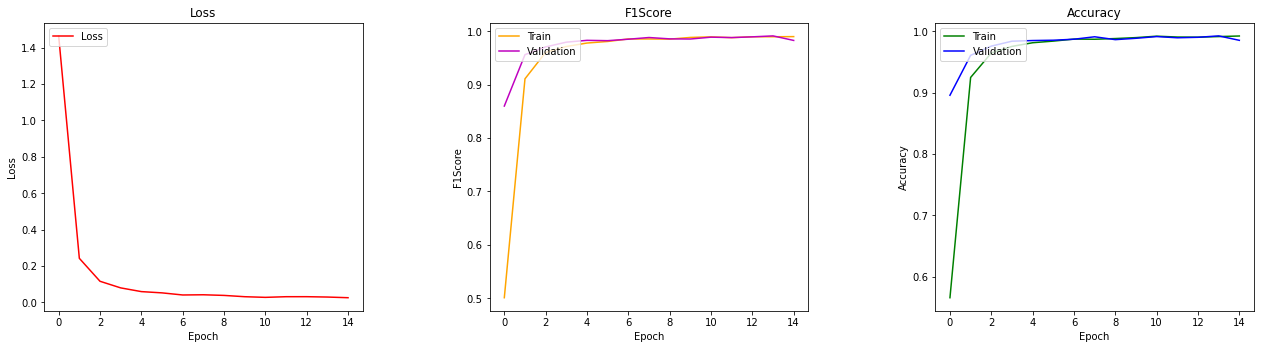

In [ ]:
for m in models_to_run:
  if m<0:
    aug=False
    m*=-1
  else:
    aug=True
    
  if m==1: 
    images, labels, x_train, x_test, y_train, y_test, input_shape = init_data(75,75,aug)
    my_network(0)
    print(3*'\n')
  elif m==2: 
    images, labels, x_train, x_test, y_train, y_test, input_shape = init_data(75,75,aug)
    my_network_deeper(0)
    print(3*'\n')
  elif m==100:
    images, labels, x_train, x_test, y_train, y_test, input_shape = init_data(75,75,aug)
    VGG16_net(1)
    print(3*'\n')
  elif m==200:
    images, labels, x_train, x_test, y_train, y_test, input_shape = init_data(75,75,aug)
    VGG19_net(1)
    print(3*'\n')
  elif m==300:
    images, labels, x_train, x_test, y_train, y_test, input_shape = init_data(75,75,aug)
    ResNet50V2_net(2)
    print(3*'\n')
  elif m==400:
    images, labels, x_train, x_test, y_train, y_test, input_shape = init_data(75,75,aug)
    InceptionV3_net(3)
    print(3*'\n')
  